# Проект для «Викишоп» #

# Содержание #
<div>
    <ol>
        <li>
            <a href="#project">Проект для «Викишоп»</a>
        </li>
        <ul>
            <li>
                <a href="#project_description">Описание проекта</a>
            </li>
            <li>
                <a href="#project_instruction">Инструкция по выполнению проекта</a>
            </li>
            <li>
                <a href="#project_data_description">Описание данных</a>
            </li>
        </ul>
        <li>
            <a href="#import_libs">Импорт библиотек</a>
        </li>
        <li>
            <a href="#data">Данные</a>
        </li>
        <ul>
            <li>
                <a href="#data_load">Загрузка данных</a>
            </li>
            <li>
                <a href="#data_first_view">Первичный осмотр данных</a>
            </li>
            <li>
                <a href="#data_class_balance">Оценка балланса классов</a>
            </li>
        </ul>
        <li>
            <a href="#prepare">Подготовка</a>
        </li>
        <ul>
            <li>
                <a href="#prepare_clear">Очистка данных от лишних символов</a>
            </li>
            <ul>
                <li>
                    <a href="#prepare_clear_func">Функция очистки/лемматизации данных</a>
                </li>
            </ul>
            <li>
            <li>
                <a href="#prepare_feature_target">Создание наборов features/target</a>
            </li>
            <li>
                <a href="#prepare_train_test">Создание учебного/тестового наборов данных</a>
            </li>
            <li>
                <a href="#prepare_class_balance">Увеличение выборки</a>
            </li>
            <ul>
                <li>
                    <a href="#prepare_class_balance_func">Функция увеличения выборки</a>
                </li>
            </ul>
            <li>
                <a href="#prepare_tf_idf_features">Векторизация признаков</a>
            </li>
        </ul>
        <li>
            <a href="#hyperparams">Гиперпараметры моделей</a>
        </li>
        <ul>
            <li>
                <a href="#hyperparams_grid_func">Функция возвращающая набор гиперпараметров используемых моделей</a>
            </li>
            <li>
                <a href="#hyperparams_gridsearch_func">Функция подбора гиперпараметров используемых моделей</a>
            </li>
            <li>
                <a href="#hyperparams_log_reg_up">Подбор гиперпараметров LogisticRegression для увеличенной выборки</a>
            </li>
            <li>
                <a href="#hyperparams_log_reg_bal">Подбор гиперпараметров LogisticRegression class_weight='balanced'</a>
            </li>
        </ul>
        <li>
            <a href="#predict">Прогноз</a>
        </li>
        <ul>
            <li>
                <a href="#predict_log_regression_up">Прогноз модели LogisticRegression для увеличенной выборки</a>
            </li>
            <li>
                <a href="#predict_log_regression_bal">Прогноз модели LogisticRegression class_weight='balanced'</a>
            </li>
        </ul>
    </ol>
</div>

<a id='import_libs'></a>
# Импорт библиотек #

In [1]:
import warnings
import time

import pandas as pd
from IPython.core.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
warnings.filterwarnings('ignore')
state = 80

/tmp/ipykernel_18056/1698642592.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


<a id='data'></a>
# Данные #

<a id='data_load'></a>
## Загрузка данных ##

In [2]:
data = pd.read_csv('datasets/toxic_comments.csv')
data['text'] = data['text'].values.astype('U')
display(data)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


<a id='data_first_view'></a>
## Первичный осмотр данных ##

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
data.describe()

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [5]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [6]:
data.query('text == ""')

,text,toxic


<a id='data_class_balance'></a>
## Оценка балланса классов ##

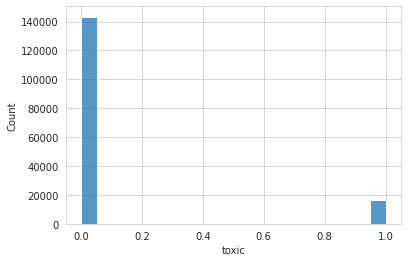

In [7]:
fig = sns.histplot(data=data['toxic'])
plt.show()

## Итоги первичного осмотра данных ##
1. пропущенные значения отсутствуют
2. классы несбаллансированны =>
    необходимо использовать параметр моделей ~class_weight = balanced, или провести баллансировку классов самостоятельно.

<a id='prepare'></a>
# Подготовка #

<a id='prepare_clear'></a>
## Очистка данных от лишних символов ##

<a id='prepare_clear_func'></a>
### Функция очистки/лемматизации данных ###

In [8]:
m = Mystem()
def data_clear_lemmatize(text):

    text = re.sub(pattern='[^a-zA-Z ]',
                  repl=' ',
                  string=text.strip())
    return ''.join(m.lemmatize(text=text))

data['text'] = data['text'].apply(lambda x: data_clear_lemmatize(x))

<a id='prepare_feature_target'></a>

## Создание наборов features/target ##

In [9]:
features = data['text']
target = data['toxic']

<div class="alert alert-block alert-success">
<b>Успех:</b> Очистка была сделана правильно.
</div>

<a id='prepare_train_test'><a/>
## Создание учебного/тестового наборов данных ##

In [10]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.3,
                                                                            random_state=state,
                                                                            shuffle=True)

<a id='prepare_class_balance'></a>
## Увеличение выборки ##

<a id='prepare_class_balance_func'></a>
### Функция увеличения выборки ###

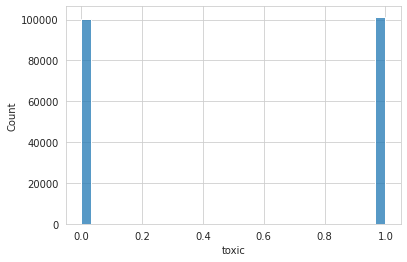

In [11]:
def upsample_func(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=state)

    return features_upsampled, target_upsampled

features_train_upsampled, target_train_upsampled = upsample_func(features_train, target_train, 9)

fig = sns.histplot(data=target_train_upsampled)
plt.show()

<a id=prepare_tf_idf_features></a>
## Векторизация признаков ##

In [12]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)
train_tf_idf_up = count_tf_idf.fit_transform(features_train_upsampled)
train_tf_idf_bal = count_tf_idf.fit_transform(features_train)
test_tf_idf = count_tf_idf.transform(features_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/parabatareek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id='hyperparams'></a>
# Гиперпараметры моделей #

<a id='hyperparams_grid_func'></a>
## Функция возвращающая набор гиперпараметров используемых моделей ##

In [13]:
def func_get_search_params(clf_name):
    params = {'LogisticRegression' : {'C' : [100, 10, 1.0, 0.1, 0.01],
                                      'solver' : ['lbfgs', 'liblinear']}}
    return params[clf_name]

<a id='hyperparams_gridsearch_func'></a>
## Функция подбора гиперпараметров используемых моделей ##

In [14]:
def get_grid_params_func(clf):
    grid = GridSearchCV(clf,
                        param_grid=func_get_search_params(clf_name=type(clf).__name__),
                        scoring='f1',
                        n_jobs=6,
                        cv=5)
    return grid

<a id='hyperparams_log_reg_up'></a>
## Подбор гиперпараметров LogisticRegression для увеличенной выборки ##

In [15]:
clf_log_reg = LogisticRegression(random_state=state)

grid = get_grid_params_func(clf=clf_log_reg)

grid.fit(X=train_tf_idf_up,
         y=target_train_upsampled)

log_reg_params_up = grid.best_params_
display(log_reg_params_up)

/home/parabatareek/venv/venv3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/parabatareek/venv/venv3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

{'C': 100, 'solver': 'lbfgs'}

<a id='hyperparams_log_reg_bal'></a>
## Подбор гиперпараметров LogisticRegression class_weight='balanced' ##

In [16]:
clf_log_reg = LogisticRegression(random_state=state, class_weight='balanced')

grid = get_grid_params_func(clf=clf_log_reg)

grid.fit(X=train_tf_idf_bal,
         y=target_train)

log_reg_params_bal = grid.best_params_
display(log_reg_params_bal)

/home/parabatareek/venv/venv3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/parabatareek/venv/venv3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

{'C': 10, 'solver': 'liblinear'}

<a id='predict'></a>
# Прогноз #

In [17]:
result = pd.DataFrame(columns=['Модель', 'F1 score', 'Время работы', 'Тип выборки'])

<a id='predict_log_regression_up'></a>
## Прогноз модели LogisticRegression для увеличенной выборки ##

In [18]:
clf = LogisticRegression(random_state=state).set_params(**log_reg_params_up)

clf.fit(X=train_tf_idf_up,
        y=target_train_upsampled)

start = time.time()
prediction = clf.predict(X=test_tf_idf)
end = time.time()

score = f1_score(y_true=target_test,
                 y_pred=prediction)
result = result.append({'Модель':type(clf).__name__,
                        'F1 score':score,
                        'Время работы': end - start,
                        'Тип выборки': 'upsampling'}, ignore_index=True)

<a id='predict_log_regression_bal'></a>
## Прогноз модели LogisticRegression class_weight='balanced' ##

In [19]:
clf = LogisticRegression(random_state=state, class_weight='balanced').set_params(**log_reg_params_bal)

clf.fit(X=train_tf_idf_bal,
        y=target_train)

start = time.time()
prediction = clf.predict(X=test_tf_idf)
end = time.time()

score = f1_score(y_true=target_test,
                 y_pred=prediction)
result = result.append({'Модель':type(clf).__name__,
                        'F1 score':score,
                        'Время работы': end - start,
                        'Тип выборки': 'balanced'}, ignore_index=True)

In [20]:
display(result)

,Модель,F1 score,Время работы,Тип выборки
0,LogisticRegression,0.747355,0.006609,upsampling
1,LogisticRegression,0.770989,0.00492,balanced


# Вывод #
С использованием приема балансировки классов - upsampling удалось добиться заданного значения метрики F1 для всех представленных моделей.
Заданное значение метрики f1 >= 0.75 достигнуто для модели логистической регресии, с использованием баллансировщика классов модели.
Значение метрики f1 = 0.77.
Время формирования прогноза составило 0.003 секунды.

Значение метрики f1 на наборе данных подвергнутому upsampling = 0.74.
Время формирования прогноза для модели обученной на upsampling  данных составило 0.004 секунды.

